In [1]:
import requests
import os
import json

def fetch_noaa_data(api_key):
    base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    dataset_id = "GHCND"
    location_id = "ZIP:80249"
    date_ranges = [
        ("2008-12-15", "2009-01-21"),
        ("2009-12-15", "2010-01-21"),
        ("2010-12-15", "2011-01-21"),
        ("2011-12-15", "2012-01-21"),
        ("2012-12-15", "2013-01-21"),
        ("2013-12-15", "2014-01-21"),
        ("2014-12-15", "2015-01-21"),
        ("2015-12-15", "2016-01-21"),
        ("2016-12-15", "2017-01-21"),
        ("2017-12-15", "2018-01-21"),
        ("2018-12-15", "2019-01-21"),
        ("2019-12-15", "2020-01-21"),
        ("2020-12-15", "2021-01-21"),
        ("2021-12-15", "2022-01-21")
    ]
    
    # Create 'data' directory if it does not exist
    if not os.path.exists('data'):
        os.makedirs('data')

    for start_date, end_date in date_ranges:
        params = {
            "datasetid": dataset_id,
            "locationid": location_id,
            "startdate": start_date,
            "enddate": end_date,
            "units": "standard",
            "limit": 1000,
        }
        headers = {"token": api_key}  # Include API key in headers
        try:
            response = requests.get(base_url, params=params, headers=headers)
            response.raise_for_status()  # Raise an exception for HTTP errors
            data = response.json()
            with open(f"data/winter_{start_date.split('-')[0]}-{end_date.split('-')[0]}.json", "w") as f:
                json.dump(data, f)
        except requests.exceptions.HTTPError as err:
            print(f"HTTP error occurred: {err}")
        except json.JSONDecodeError as err:
            print(f"Error decoding JSON response: {err}")
        except Exception as err:
            print(f"An unexpected error occurred: {err}")

# NOAA API key
api_key = "aQxLGxOGvBgqVedWxLBqsuxrzQnPRhSb"
fetch_noaa_data(api_key)


In [2]:
import json
import pandas as pd

def json_to_csv():
    # Combine all JSON files into a single DataFrame
    df_list = []
    for year in range(2008, 2022):
        file_name = f"data/winter_{year}-{year + 1}.json"
        with open(file_name) as f:
            data = json.load(f)
            df = pd.json_normalize(data["results"])
            df_list.append(df)
    final_df = pd.concat(df_list)
    
    # Extract required columns and calculate TAVG
    final_df["date"] = pd.to_datetime(final_df["date"])
    final_df = final_df.pivot_table(index=["date"], columns="datatype", values="value", aggfunc="mean")
    final_df["TAVG"] = (final_df["TMAX"] + final_df["TMIN"]) / 2
    
    # Export DataFrame to CSV
    final_df.to_csv("data/all_data_max_min_avg.csv")

json_to_csv()


In [3]:
import pandas as pd

def average_warmest(df):
    """
    Compute the average of the warmest temperatures in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing temperature data.

    Returns:
    float: Average of the warmest temperatures in the DataFrame.
    """
    # Convert 'TMAX' column to numeric
    df['TMAX'] = pd.to_numeric(df['TMAX'], errors='coerce')

    # Drop rows with missing values in 'TMAX' column
    cleaned_data = df.dropna(subset=['TMAX'])

    # Compute the average of the 'TMAX' column
    avg_warmest_temperature = cleaned_data['TMAX'].mean()

    return avg_warmest_temperature

# Load the DataFrame from the CSV file
weather_data = pd.read_csv("data/all_data_max_min_avg.csv")

# Call the function with your DataFrame
avg_warmest_temp = average_warmest(weather_data)
print("Average of the warmest temperatures:", avg_warmest_temp)


Average of the warmest temperatures: 43.866279069767444


In [4]:
def average_coldest(df):
    """
    Compute the average of the coldest temperatures in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing temperature data.

    Returns:
    float: Average of the coldest temperatures in the DataFrame.
    """
    # Convert 'TMIN' column to numeric
    df['TMIN'] = pd.to_numeric(df['TMIN'], errors='coerce')

    # Drop rows with missing values in 'TMIN' column
    cleaned_data = df.dropna(subset=['TMIN'])

    # Compute the average of the 'TMIN' column
    avg_coldest_temperature = cleaned_data['TMIN'].mean()

    return avg_coldest_temperature

# Call the function with your DataFrame
avg_coldest_temp = average_coldest(weather_data)
print("Average of the coldest temperatures:", avg_coldest_temp)


Average of the coldest temperatures: 17.4437984496124


In [5]:
# Step 4: Compute the average of the DataFrame
if 'date' in weather_data.columns:
    avg_data = weather_data.drop('date', axis=1).mean()
else:
    avg_data = weather_data.mean()
print("Average of the DataFrame:")
print(avg_data)


Average of the DataFrame:
ADPT      -98.436992
ASLP    10163.997959
ASTP     8311.159184
AWBT      -39.859756
AWND        9.512016
DAPR        2.000000
FMTM     1346.570175
MDPR        0.250000
PGTM     1369.260870
PRCP        0.015564
PSUN       81.736842
RHAV       55.168016
RHMN       35.050607
RHMX       75.694332
SNOW        0.238113
SNWD        0.626255
TAVG       30.655039
TMAX       43.866279
TMIN       17.443798
TSUN      465.210526
WDF2      195.872093
WDF5      200.000000
WSF2       20.730233
WSF5       25.775340
WT01        1.000000
WT02        1.000000
WT03        1.000000
WT06        1.000000
WT07        1.000000
WT08        1.000000
WT09        1.000000
WT11        1.000000
WT13        1.000000
WT14        1.000000
WT15        1.000000
WT16        1.000000
WT17        1.000000
WT18        1.000000
WT22        1.000000
dtype: float64


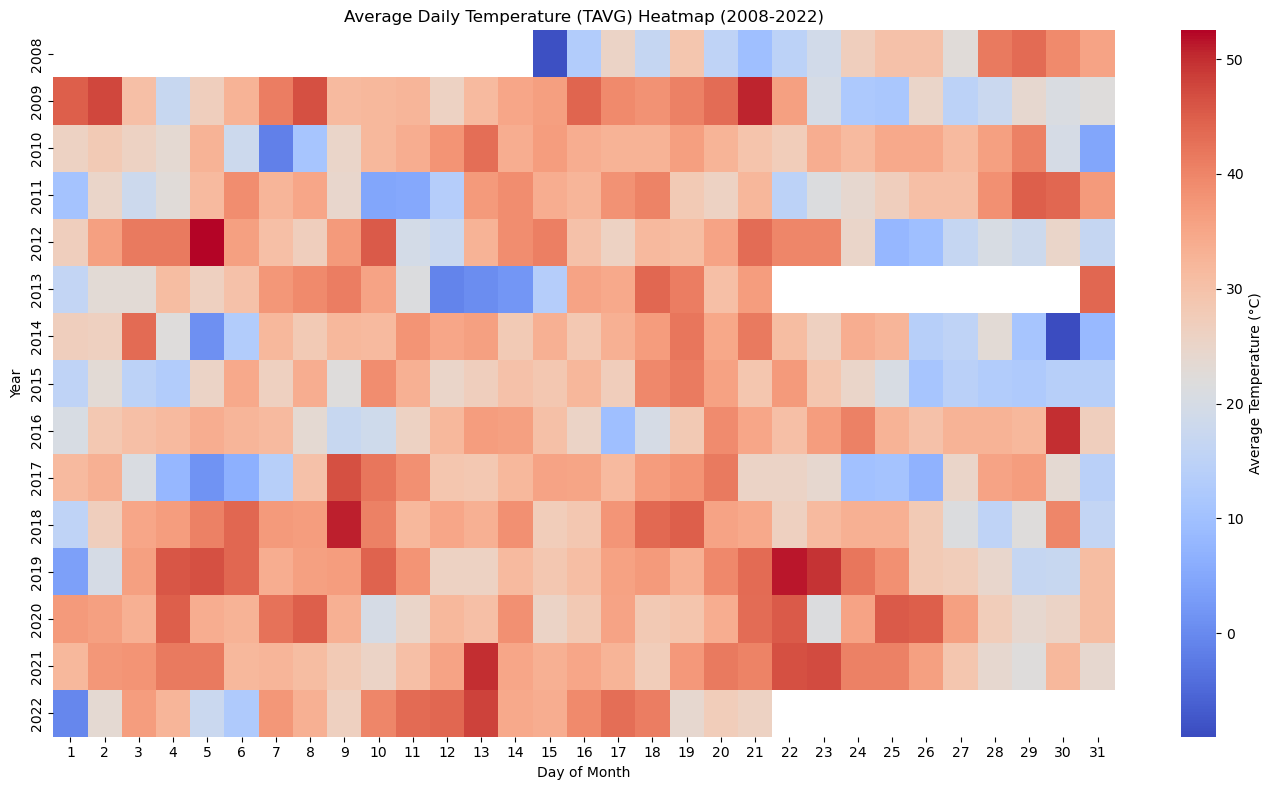

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Convert 'date' column to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Set the 'date' column as the index
weather_data.set_index('date', inplace=True)

# Extract the year, month, and day from the index
weather_data['Year'] = weather_data.index.year
weather_data['Month'] = weather_data.index.month
weather_data['Day'] = weather_data.index.day

# Pivot the DataFrame to have years as rows and days as columns, with TAVG values as the entries
pivot_data = weather_data.pivot_table(index='Year', columns='Day', values='TAVG')

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_data, cmap='coolwarm', cbar_kws={'label': 'Average Temperature (°C)'})
plt.title('Average Daily Temperature (TAVG) Heatmap (2008-2022)')
plt.xlabel('Day of Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()
